# Project on classifying whether a review is positive or not for Amazon Fine Foods

In [1]:
%matplotlib inline

#insert required modules
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#load the database file
con=sqlite3.connect('D:\Applied AI Course\database.sqlite')

In [3]:
#query files
filt_data=pd.read_sql_query("""SELECT * FROM REVIEWS WHERE score!=3""",con)

In [4]:
#check data and shape
print(filt_data.shape)
print(filt_data.head())

(525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality can

In [5]:
import pickle

def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [6]:
#change the Score field to Review and assign as positive or negative either using lambdas or a custom function
#using custom function
def partition(x):
    if x < 3:
        return 'Negative'
    return 'Positive'

#using lambdas
#filt_data['Score']=filt_data['Score'].apply(lambda x: 'Positive' if int(x)>3 else 'Negative')

In [7]:
#change column
ActScore=filt_data['Score']
positiveNegative=ActScore.map(partition)
filt_data['Score']=positiveNegative

In [146]:
filt_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
filt_data.shape

(525814, 10)

In [10]:
import gensim
from gensim.models import word2vec,KeyedVectors

D:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data cleaning-removing duplicate entries

In [11]:
dup_data=pd.read_sql_query("""SELECT * FROM REVIEWS WHERE score!=3 ORDER BY ProductId """,con)

In [12]:
dup_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
1,150494,0006641040,AYZ0PR5QZROD1,Mother of 3 girls,3,3,5,1173312000,Family favorite,All of my children love this book. My first g...
2,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,5,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...
3,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
4,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...
5,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,5,1065830400,Can't explain why,This book has been a favorite of mine since I ...
6,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,5,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
7,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
8,150502,0006641040,AVFMJ50HNO21J,Jane Doe,1,1,4,1324944000,"Tiny little book, Wonderful little rhymes.",This copy is smaller than I expected (mostly b...
9,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,5,1233964800,so fun to read,This is my grand daughter's and my favorite bo...


In [145]:
#the product id 0006641040 is a book and not a fine food and hence to be removed
sort_data=filt_data.sort_values('ProductId',axis=0,ascending=True)
sort_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [14]:
final_data=sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

In [15]:
percent=(final_data['Id'].size*1.0 / filt_data['Id'].size*1.0) *100
print(percent)

69.25890143662969


In [16]:
final_data["Score"].value_counts()

Positive    307063
Negative     57110
Name: Score, dtype: int64

In [143]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [18]:
dup_data1=pd.read_sql_query("""SELECT DISTINCT ProductId,UserId FROM REVIEWS WHERE score!=3 AND ProductId='0006641040' ORDER By ProductId """,con)

In [19]:
dup_data1.shape

(34, 2)

In [22]:
labels=final_data['Score']

In [24]:
labels.head(3)

138706    Positive
138688    Positive
138689    Positive
Name: Score, dtype: object

# BOW,TFIDF,Word2Vec(Avg-W2Vec,TfIDF-W2Vec) t-SNE plots

In [25]:
#helper functions

stop_word=set(stopwords.words('english'))
sno=SnowballStemmer('english')

def cleanhtml(sentence):
    cleanh=re.compile('<.*?>')
    cleantext=re.sub(cleanh,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return cleaned

print(stop_word)
print("##################################################")
print(sno.stem('tasty'))


{'at', 'up', 'into', 'under', 'most', 'don', 'but', "haven't", "you'll", 'himself', 'all', "shan't", 'hers', 'is', "it's", 'its', 'it', 'other', 'aren', 'we', "needn't", "weren't", 'any', 'y', 'their', 'herself', 'i', 'they', 'by', 'm', "aren't", 'themselves', 'do', 'couldn', 'on', "wasn't", 'now', 'which', 'very', 'of', "won't", 'an', "shouldn't", 'out', 'ours', "you're", 'her', 'down', 'll', 'should', 'where', 'that', 'me', "you'd", 'doing', 'some', 'mightn', 'after', 'as', 'yours', 'than', 'my', 'about', 'been', 'same', 'how', 'itself', 'while', "doesn't", 'haven', 'what', 'he', 'own', 'isn', "didn't", 'she', 'did', 'too', 'am', 'above', 'in', 'having', 'once', 'yourselves', 'over', 'only', 'won', 'then', 'the', 'and', 'them', 'here', 'both', "you've", 'myself', 'will', 'him', 'd', 'during', 'against', 'not', 'so', "don't", 'ourselves', 'yourself', "hadn't", 'didn', 'when', 'this', 've', 'nor', 'ma', 'ain', 'why', "mightn't", 'these', 'further', 'such', 'with', 'few', "wouldn't", 'e

In [26]:
#code to check for implemented checks above
i=0
str1=''
final_string=[]
all_pos_words=[]
all_neg_words=[]
s=''

for sent in final_data['Text'].values:
    filtered_sentences=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop_word):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentences.append(s)
                    if (labels.values)[i]=='Positive':
                        all_pos_words.append(s)
                    if (labels.values)[i]=='Negative':
                        all_neg_words.append(s)
                else:
                    continue
            else:
                continue
        
    str1=b" ".join(filtered_sentences)
       
    final_string.append(str1)
    i +=1
        
        
                    
                    


In [27]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf8")



D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [142]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [29]:
#save it to database
conn=sqlite3.connect('final2.sqlite')
c=conn.cursor()
#c.execute("alter table REVIEWS add column '%s'" %labels)
conn.commit()
conn.text_factory=str
final_data.to_sql('Reviews',conn,schema=None,if_exists='replace')

In [30]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [119]:
n_samples=2000
test_data=final_data.sample(n_samples)
label_data=final_data['Score'][0:2000]

In [141]:
test_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
438074,473737,B000FCI6T0,A3K05ROKCA9BD3,"Cynde ""cyndec""",2,2,Positive,1172707200,Really fresh!,I received this box as a gift from my husband ...,receiv box gift husband valentin day real trea...
326423,353276,B000HEA8Q0,A1LZUDRS218G1R,DMM-NH,4,4,Positive,1294617600,Amost excellent product,I looked for this product for years. Quite acc...,look product year quit accident found tea shop...
50185,54488,B001TLY7A8,A20X2L5P94PZPF,Diana L. Gray,0,0,Positive,1287100800,Roxie loves this food!,I've tried numerous canned -grain free- foods ...,ive tri numer can food cat roxi doesnt care op...
13970,15247,B00503DP0O,A1H6SBO7R007I8,A. Reader,2,2,Positive,1313625600,amazing delicious fantastic,"Sure it says 'Oat' bar, but make no mistake th...",sure say oat bar make mistak indulg amaz proab...
372411,402730,B0043H35YO,A3K4TWQOC43MXX,"michelle ""michelle""",0,0,Positive,1341187200,great to get rid of garlic breath,"i tried this for the first time in NY, and lo...",tri first time love bought amazon happybut bad...


In [120]:
#bag of words
count_vect=CountVectorizer()
final_count=count_vect.fit_transform(test_data['CleanedText'].values)
type(final_count)
final_count.get_shape()
#Bi-grams and n-grams

freq_dist_pos=nltk.FreqDist(all_pos_words)
freq_dist_neg=nltk.FreqDist(all_neg_words)
print("Most common positive words:",freq_dist_pos.most_common(20))
print("Most common negative words:",freq_dist_neg.most_common(20))

#Bi-grams
#count_vect=CountVectorizer(ngram_range=(1,2))
#final_count=count_vect.fit_transform(test_data['CleanedText'].values)


Most common positive words: [(b'like', 139075), (b'tast', 128082), (b'good', 112017), (b'flavor', 108655), (b'love', 107021), (b'use', 103604), (b'great', 103096), (b'one', 96539), (b'product', 90274), (b'tri', 86413), (b'tea', 83290), (b'coffe', 77985), (b'make', 74915), (b'get', 72030), (b'food', 64244), (b'would', 55457), (b'time', 54848), (b'buy', 54031), (b'realli', 52613), (b'eat', 51790)]
Most common negative words: [(b'tast', 34300), (b'like', 32225), (b'product', 28003), (b'one', 20521), (b'flavor', 19368), (b'would', 17947), (b'tri', 17691), (b'use', 15263), (b'good', 14908), (b'coffe', 14579), (b'get', 13770), (b'buy', 13711), (b'order', 12832), (b'food', 12643), (b'dont', 11808), (b'tea', 11574), (b'even', 11042), (b'box', 10734), (b'make', 9823), (b'time', 9720)]


# Bag Of Words

In [32]:
#bag of words
count_vect=CountVectorizer()
final_count=count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer is:",type(final_count))
final_count.get_shape()

the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>


(364173, 120724)

In [33]:
final_count.get_shape

<bound method spmatrix.get_shape of <364173x120724 sparse matrix of type '<class 'numpy.int64'>'
	with 11452731 stored elements in Compressed Sparse Row format>>

In [34]:
#t-SNE plot for Bag of words
#from sklearn.preprocessing import StandardScaler

#standard_data=StandardScaler(with_mean=False).fit_transform(final_count)
#standard_data.shape

In [35]:
n_samples=1000
std_data=final_count[0:n_samples,:n_samples].todense()
label_data=final_data["Score"][0:n_samples]

In [36]:
std_data.shape

(1000, 1000)

D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


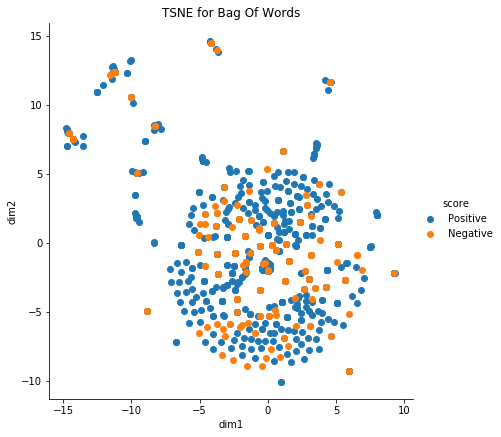

In [37]:
from sklearn.manifold import TSNE

tmodel=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
tsne_data=tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag Of Words")
plt.show()

# TF-IDF

In [38]:
#tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect=TfidfVectorizer()
final_tf_idf_vect=tf_idf_vect.fit_transform(final_data["CleanedText"].values)
final_tf_idf_vect.get_shape()
#get features
features=tf_idf_vect.get_feature_names()
print(len(features))
print("type of count vectorizer :",type(final_tf_idf_vect))

120724
type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>


In [39]:
#top tdf-idf features code taken from https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_vect[1,:].toarray()[0],features,25)

In [40]:
top_tfidf

,feature,tfidf
0,sendak,0.359946
1,paperback,0.348872
2,rosi,0.320880
3,flimsi,0.259566
4,incorpor,0.247205
5,page,0.222703
6,movi,0.212070
7,book,0.202037
8,grew,0.195787
9,cover,0.176995


D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


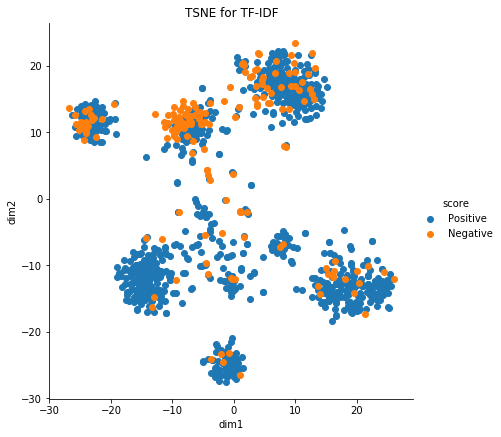

In [41]:
#t-SNE visualization for tf-idf
n_samples=1000
std_data=final_tf_idf_vect[0:n_samples,:].todense()
label_data=final_data["Score"][0:n_samples]

#from sklearn.manifold import TSNE

tmodel=TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
tsne_data=tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

In [121]:
savetofile(final_tf_idf_vect,"tfidf")

# Word2Vec

In [65]:
pwd

'C:\\Users\\Tejas'

In [123]:
##Create own word2vec model

i=0
list_of_sentence=[]
for sent in test_data['CleanedText'].values:
    list_of_sentence.append(sent.split())
    #sent=cleanhtml(sent)
    #for w in sent.split():
        #for cleaned in cleanpunc(w).split():
            #if(cleaned.isalpha()):
                #filtered_sentence.append(cleaned.lower())
            #else:
                #continue
        #list_of_sentence.append(filtered_sentence)
print(test_data['CleanedText'].values[0])
print('###########')
print(list_of_sentence[0])
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

words=list(w2v_model.wv.vocab)
print(len(words))


receiv box gift husband valentin day real treat browni arriv fresh handl perfect chewi tasti eat bake good often especi pleas tast recommend
###########
['receiv', 'box', 'gift', 'husband', 'valentin', 'day', 'real', 'treat', 'browni', 'arriv', 'fresh', 'handl', 'perfect', 'chewi', 'tasti', 'eat', 'bake', 'good', 'often', 'especi', 'pleas', 'tast', 'recommend']
1929


In [128]:
w2v_model.save('w2vmodel')

In [129]:
print(w2v_model)

Word2Vec(vocab=1929, size=50, alpha=0.025)


In [130]:
w2v_model.wv.most_similar('tasti')

D:\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('stuff', 0.9998751282691956),
 ('come', 0.9998654127120972),
 ('cereal', 0.9998612999916077),
 ('away', 0.9998562335968018),
 ('seed', 0.9998495578765869),
 ('dri', 0.9998475909233093),
 ('also', 0.9998428225517273),
 ('pleas', 0.9998418092727661),
 ('healthi', 0.999841570854187),
 ('meal', 0.9998407959938049)]

# Avg W2V

In [132]:
#average word2vec
sent_vectors = [] 
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

vec_avg=np.array(sent_vectors)

2000
50


D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


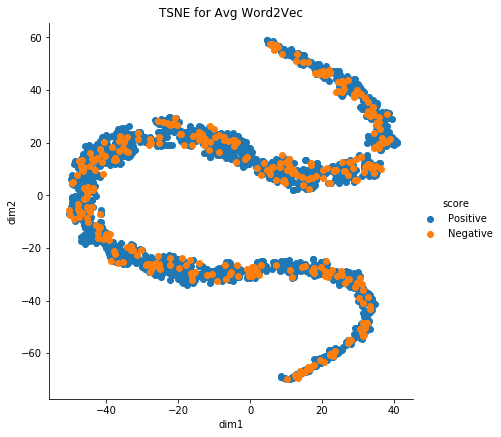

In [134]:
#n_samples=1000
std_data=vec_avg
#label_data=final_data["Score"][0:n_samples]

#from sklearn.manifold import TSNE

tmodel=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
tsne_data=tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Avg Word2Vec")
plt.show()

# TF-IDF Word2Vec t-SNE

In [135]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_vect=tf_idf_vect.fit_transform(test_data["CleanedText"].values)
final_tf_idf_vect.get_shape()
#get features
features=tf_idf_vect.get_feature_names()
print(len(features))
print("type of count vectorizer :",type(final_tf_idf_vect))

62875
type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>


In [95]:
tf_idf=openfromfile('tfidf')
tf_idf

<364173x120724 sparse matrix of type '<class 'numpy.float64'>'
	with 11452731 stored elements in Compressed Sparse Row format>

In [136]:
print("shape:",final_tf_idf_vect.get_shape())


shape: (2000, 62875)


In [137]:
from sklearn.decomposition import TruncatedSVD
s=TruncatedSVD(n_components=5, n_iter=7, random_state=42)
sample_feat_vect=s.fit_transform(final_tf_idf_vect)



In [115]:
sample_feat_vect

array([[ 0.02481256, -0.00722239, -0.00572286,  0.0020652 ,  0.00238161],
       [ 0.04156559, -0.01452842, -0.01195302,  0.00715577, -0.00262578],
       [ 0.02501641, -0.00705836, -0.00415058,  0.00195987, -0.0012734 ],
       ...,
       [ 0.0285171 , -0.00470295,  0.00358799, -0.0105155 ,  0.01320058],
       [ 0.07065738, -0.02995533, -0.01761324, -0.00174938,  0.05572974],
       [ 0.05689007, -0.02061095, -0.01080435, -0.0037914 ,  0.03055602]])

In [138]:
# TF-IDF weighted Word2Vec
tf_idf_features = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sentence: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_vect[row, tf_idf_features.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [139]:
tf_vec_avg=np.array(tfidf_sent_vectors)

D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


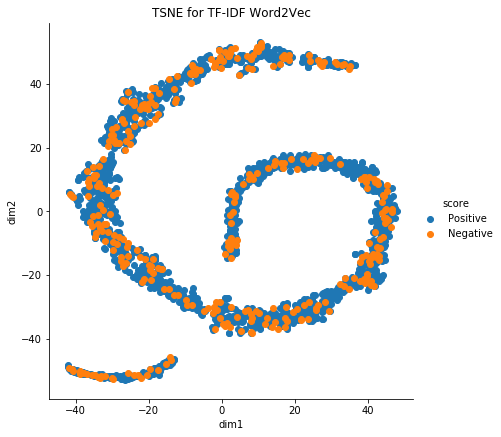

In [140]:
std_data=tf_vec_avg


#from sklearn.manifold import TSNE

tmodel=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
tsne_data=tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2Vec")
plt.show()